<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/AJUBA_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [2]:
%load_ext autoreload
%autoreload 2   

In [5]:
#helper utilities for model training and interpretation 
import shap
import sys 
sys.path.append('..')

from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost



## AJUBA xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Computational Dataset</a></li>
    <li><a href=#2>Computational Dataset Feature Subsets</a></li>
    <li><a href=#3>Exclude mut features</a></li>
 </ol>


## AJUBA Computational features <a name='1'>
<a href=#outline>Home</a>

In [6]:
data=pd.read_csv("../../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)

In [7]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [8]:
data=format_for_xgboost(data)
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(482, 195)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 22, 84.0: 22, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 10}


In [9]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [10]:
#Remove any null features 
train_null=get_high_missingness_features(train_split)
eval_null=get_high_missingness_features(eval_split)
test_null=get_high_missingness_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [11]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u3_3prm_cp_bulge:C:G
d3_5prm_cp_internal
site_5prm_cp_bulge:C:G
u3_3prm_cp_internal:G:C
d1_struct:S
d3_5prm_cp_hairpin
d2_5prm_cp_hairpin
d2_length_hairpin
d2_3prm_cp_bulge:G:U
u3_length_hairpin
u1_struct:I
u2_length_hairpin
d3_length_hairpin
u2_5prm_cp_hairpin
mut_ref_nt:U
u3_5prm_cp_hairpin
d3_length_internal_ecs
site_prev_nt:A
site_5prm_cp_hairpin
u3_length_internal_es
d2_5prm_cp_bulge:A:U
mut_prev_struct:H
u1_exist
mut_ref_nt:G
d1_length_internal_ecs
u2_5prm_cp_bulge:U:A
u3_exist
u2_length_stem
d3_struct:S
u3_length_bulge
d1_5prm_cp_bulge
d2_5prm_cp_bulge:G:U
mut_ref_nt:A
d1_distance
d2_3prm_cp_internal:C:G
u2_exist
u3_5prm_cp_internal:A:U
d3_length_bulge
u3_length_internal_ecs
d2_5prm_cp_bulge:C:G
site_prev_struct:I
u1_3prm_cp_internal:U:A
u3_5prm_cp_bulge:C:G
d1_length_internal_es
site_next_nt:A
u3_5prm_cp_internal:G:C
u2_5prm_cp_bulge:G:C
site_length_stem
site_5prm_cp_bulge:A:U
u1_5prm_cp_internal:U:A
u2_length_bulge
d1_3prm_cp_internal
d2_3prm_cp_internal:U:A
d1_5prm_cp_interna

In [12]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [13]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [14]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(326, 106)
(326,)
(77, 106)
(77,)
(99, 106)
(99,)


In [15]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [16]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [17]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [18]:
num_round = 1000
random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.73592	eval-mae:0.31387	eval-map:1.00000	eval-aucpr:0.17769	eval-rmse:0.32023	train-auc:0.71213	train-mae:0.32457	train-map:1.00000	train-aucpr:0.14579	train-rmse:0.32742
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.74168	eval-mae:0.22152	eval-map:1.00000	eval-aucpr:0.19196	eval-rmse:0.22612	train-auc:0.71646	train-mae:0.22819	train-map:1.00000	train-aucpr:0.15919	train-rmse:0.23061
[2]	eval-auc:0.75589	eval-mae:0.15639	eval-map:1.00000	eval-aucpr:0.21541	eval-rmse:0.15998	train-auc:0.71844	train-mae:0.16053	train-map:1.00000	train-aucpr:0.16453	train-rmse:0.16286
[3]	eval-auc:0.75589	eval-mae:0.11214	eval-map:1.00000	eval-aucpr:0.21541	eval-rmse:0.11568	train-auc:0.71824	train-mae:0.11304	train-map:1.00000	train-aucpr:0.16193	train-rmse:0.11546
[4]	eval-auc:0.77368	eval-mae:0.08268	eval-map:1.00000	eval-aucpr:0.21824	eval-rmse:0.08765	train-auc:0.76458	train

[44]	eval-auc:0.80227	eval-mae:0.01407	eval-map:1.00000	eval-aucpr:0.22370	eval-rmse:0.04564	train-auc:0.81341	train-mae:0.00084	train-map:1.00000	train-aucpr:0.18383	train-rmse:0.00121
[45]	eval-auc:0.80344	eval-mae:0.01404	eval-map:1.00000	eval-aucpr:0.22627	eval-rmse:0.04564	train-auc:0.81341	train-mae:0.00082	train-map:1.00000	train-aucpr:0.18383	train-rmse:0.00120
[46]	eval-auc:0.80229	eval-mae:0.01403	eval-map:1.00000	eval-aucpr:0.22370	eval-rmse:0.04567	train-auc:0.81342	train-mae:0.00079	train-map:1.00000	train-aucpr:0.18383	train-rmse:0.00114
[47]	eval-auc:0.80230	eval-mae:0.01402	eval-map:1.00000	eval-aucpr:0.22370	eval-rmse:0.04567	train-auc:0.81342	train-mae:0.00077	train-map:1.00000	train-aucpr:0.18383	train-rmse:0.00112
[48]	eval-auc:0.80228	eval-mae:0.01400	eval-map:1.00000	eval-aucpr:0.22371	eval-rmse:0.04566	train-auc:0.81344	train-mae:0.00073	train-map:1.00000	train-aucpr:0.18383	train-rmse:0.00105
[49]	eval-auc:0.80230	eval-mae:0.01399	eval-map:1.00000	eval-aucpr:0.2

In [19]:
# save to binary file for faster loading
bst.save_model('ajuba.computational.model')
# save model to text file 
bst.dump_model('ajuba.computational.raw.txt')


In [20]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [21]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.07)

Train
	Spearman corr : SpearmanrResult(correlation=0.9980668912920484, pvalue=0.0)
	Pearson corr : (0.9998403883985676, 0.0)
	MAE : 0.0007103582100174906
	MAPE : 0.023547685956806726
	RMSE : 0.0010346661015591496
	auPRC : 1.0000000000000002
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.9233135805055499, pvalue=6.690568489509657e-33)
	Pearson corr : (0.8512273950610918, 1.0718897126555647e-22)
	MAE : 0.013991101945682222
	MAPE : 0.16132763585917476
	RMSE : 0.04566585907479178
	auPRC : 1.0
	auROC : 1.0
Test
	Spearman corr : SpearmanrResult(correlation=0.9019181054947727, pvalue=3.838215627899462e-37)
	Pearson corr : (0.8751113181061647, 2.439056019387859e-32)
	MAE : 0.014140121343003397
	MAPE : 0.2618964466392025
	RMSE : 0.0340808599131525
	auPRC : 0.9369750619750621
	auROC : 0.9946332737030412


In [22]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9980668912920484, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9233135805055499, pvalue=6.690568489509657e-33)
Test:SpearmanrResult(correlation=0.9019181054947727, pvalue=3.838215627899462e-37)


Pearson correlation:
Train:(0.9998403883985676, 0.0)
Eval:(0.8512273950610918, 1.0718897126555647e-22)
Test:(0.8751113181061647, 2.439056019387859e-32)


In [23]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0007103582100174906
MAE Eval:0.013991101945682222
MAE Test:0.014140121343003397


In [24]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.3547685956806728%
MAPE Eval:16.132763585917477%
MAPE Test:26.189644663920248%


In [25]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0010346661015591496
RMSE Eval:0.04566585907479178
RMSE Test:0.0340808599131525


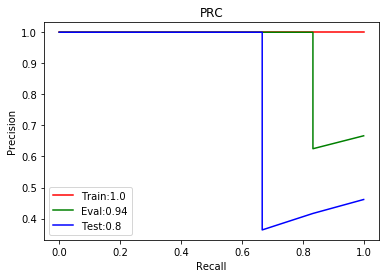

In [26]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

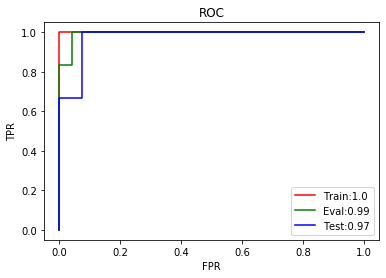

In [27]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [28]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.04440604
0.45013801208252857
0.11498899622957265
The R-square of the test data is  0.745 



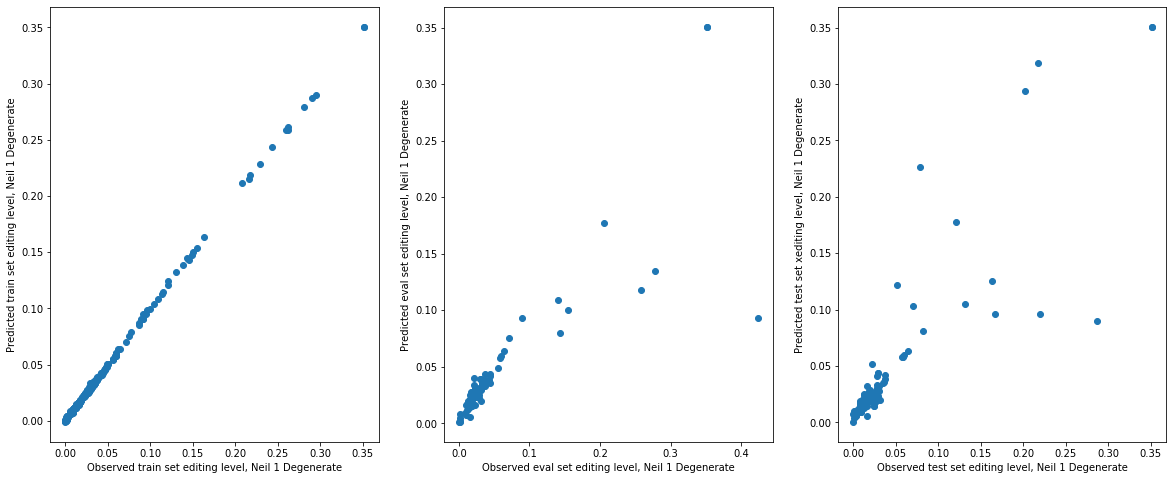

In [29]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set xediting level, Neil 1 Degenerate")

plt.show()

In [30]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'AJUBA'})

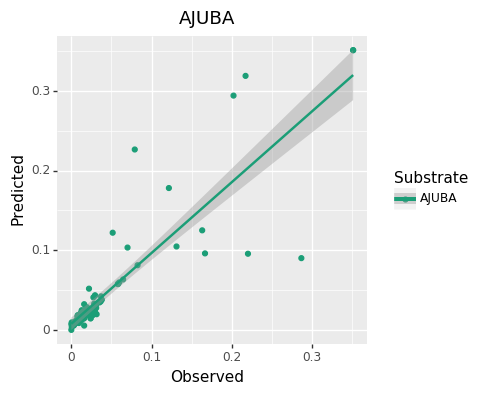

<ggplot: (8776474488937)>


In [31]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#1b9e77'],name="Substrate")
 + ggtitle("AJUBA"))
print(p)
ggsave(plot=p, filename='AJUBA.comp.substrate.svg',width=4,height=4,units='in')


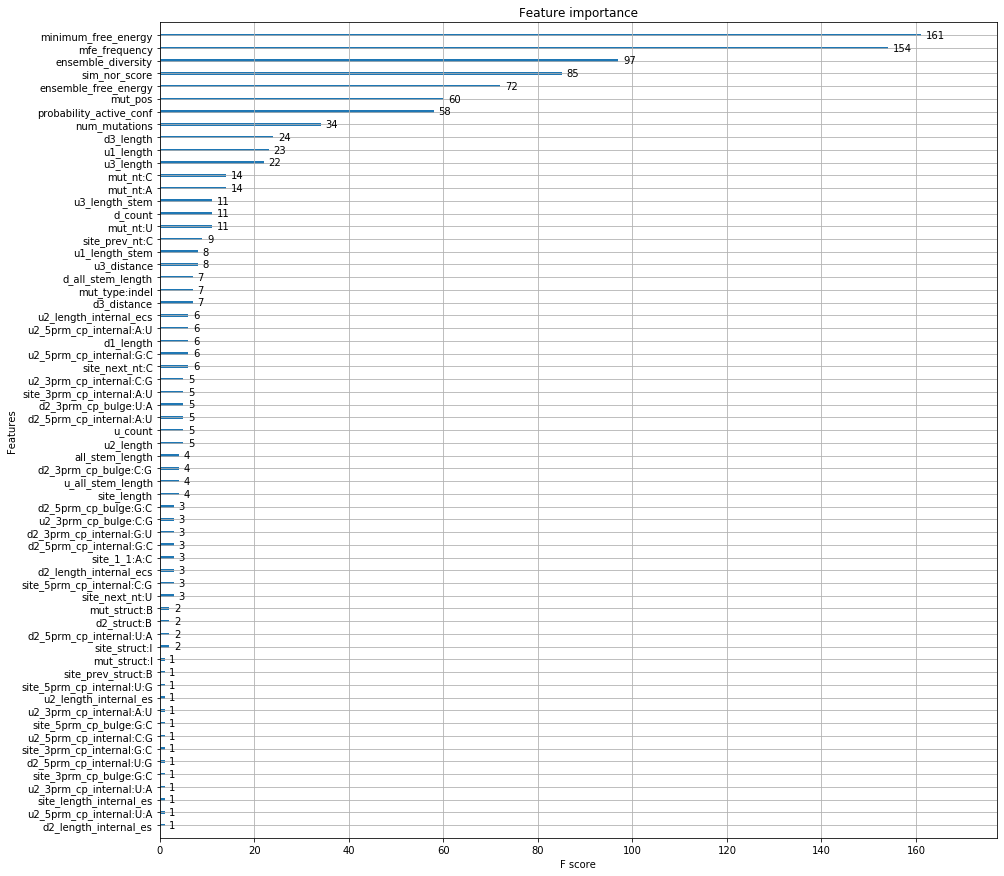

In [32]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

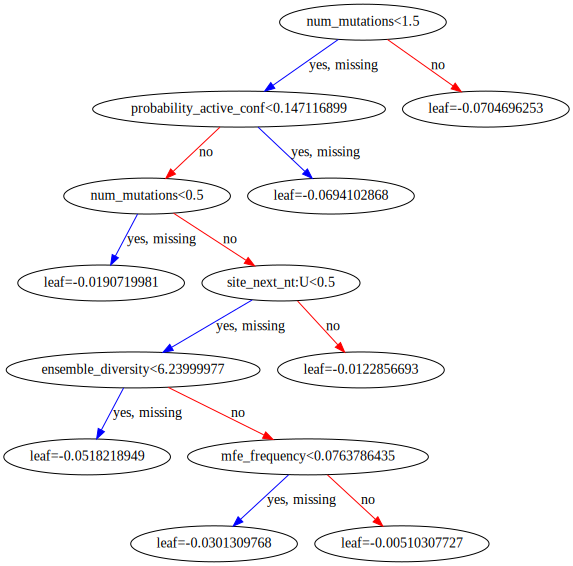

In [33]:
xgboost.to_graphviz(bst, num_trees=2)


In [34]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(99, 106)

In [35]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [36]:
 max(test_y['editing_value'])

0.35100000000000003

In [37]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [38]:
 min(test_y['editing_value'])

0.0

In [39]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

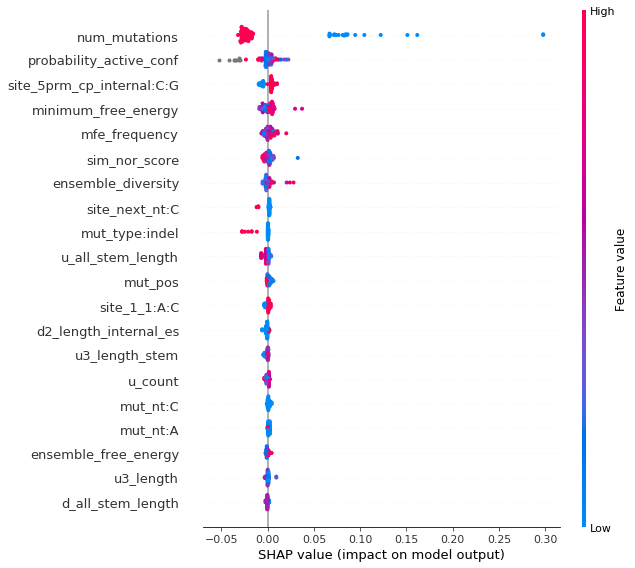

In [40]:
# summarize the effect of all the features 
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("AJUBA.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")



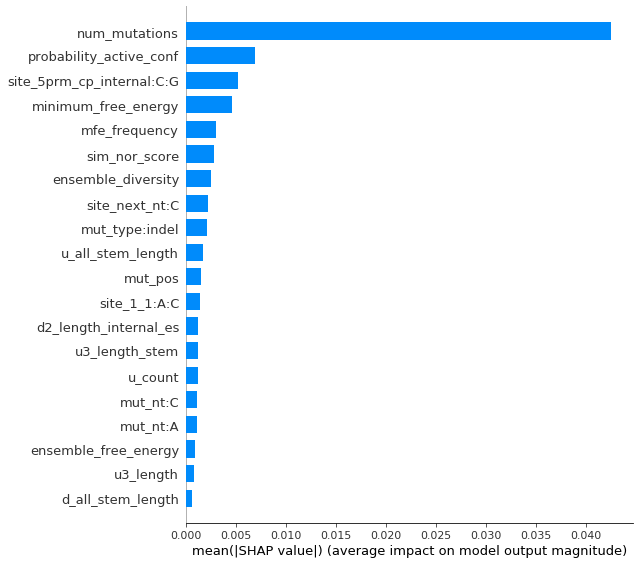

In [41]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [42]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("AJUBA_comp_shap_mean_abs.txt",index=False,sep='\t')

In [43]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(99, 106, 106)

In [44]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [45]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [47]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [48]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


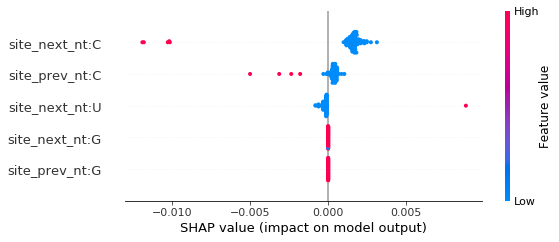

Contribution/Total:0.031964827
['free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'minimum_free_energy*', 'ensemble_free_energy*', 'mfe_frequency*', 'ensemble_diversity*']


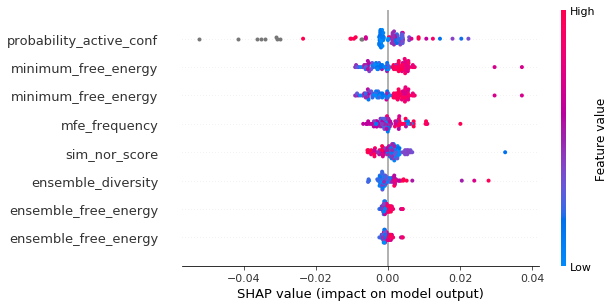

Contribution/Total:0.28285012
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


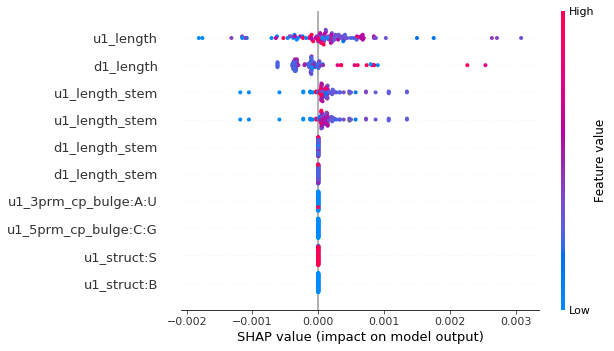

Contribution/Total:0.013604807
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


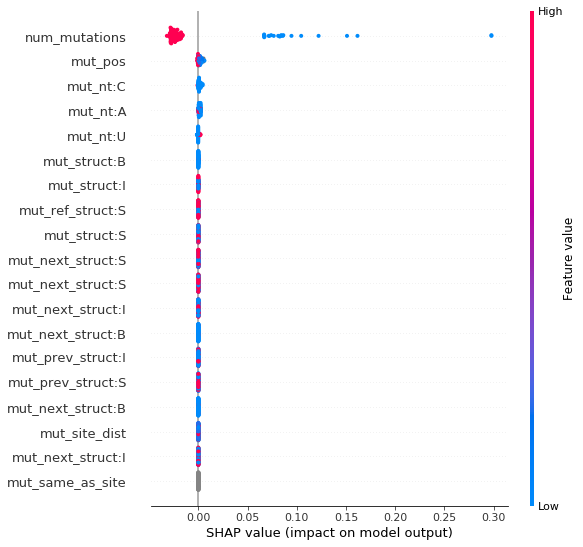

Contribution/Total:0.5095326
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


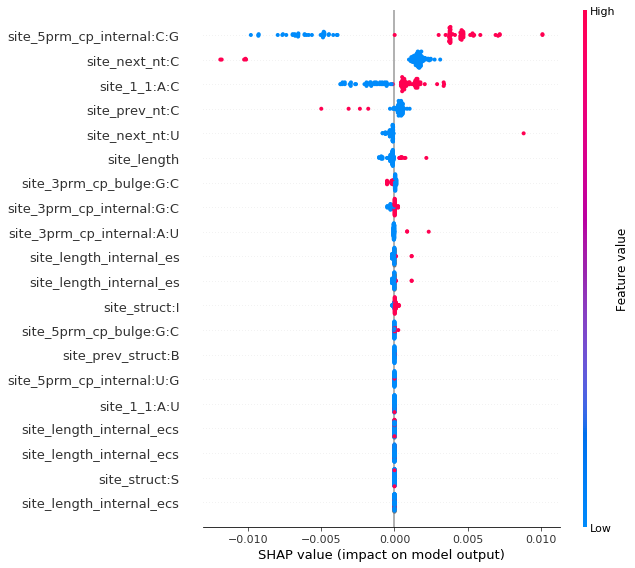

Contribution/Total:0.112280354
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


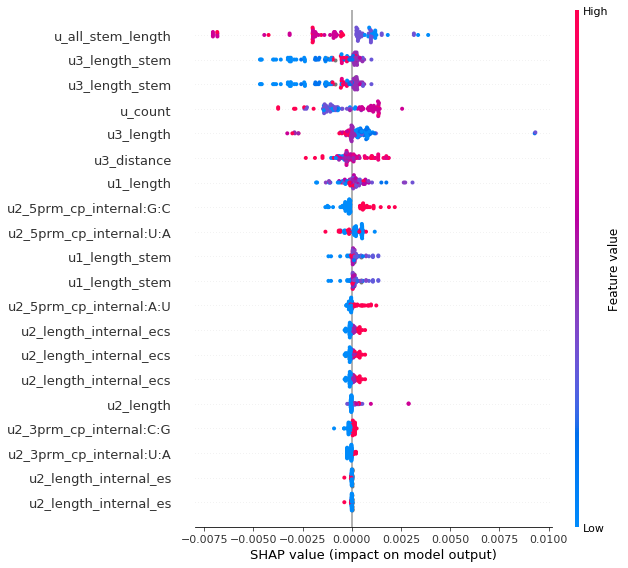

Contribution/Total:0.09989661
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


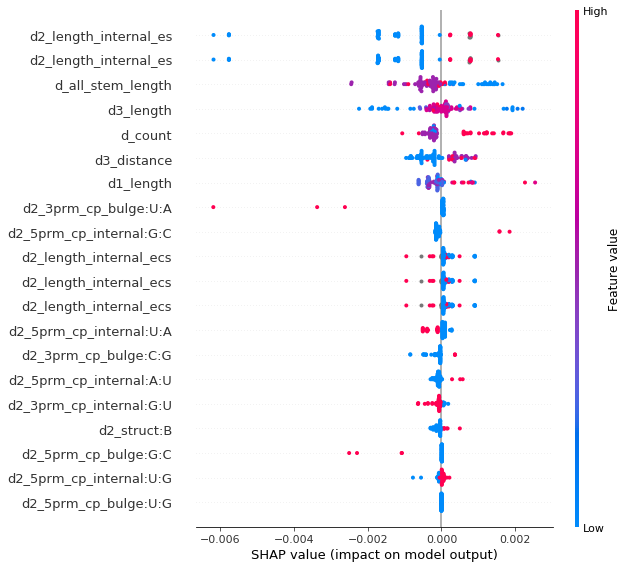

Contribution/Total:0.06695702
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

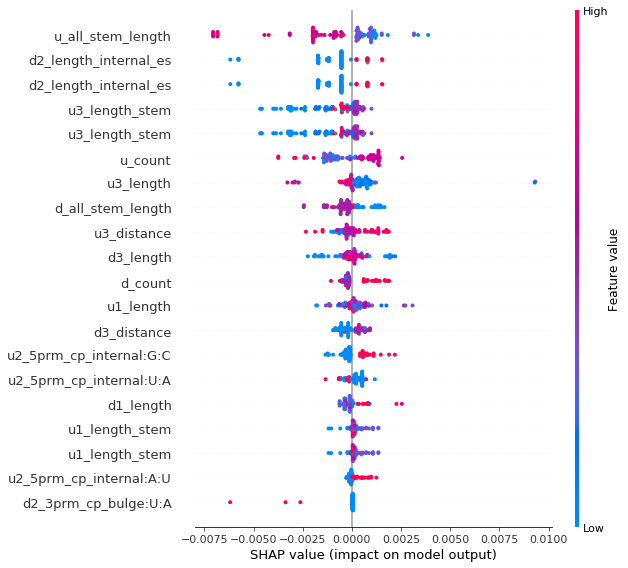

Contribution/Total:0.16685364
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


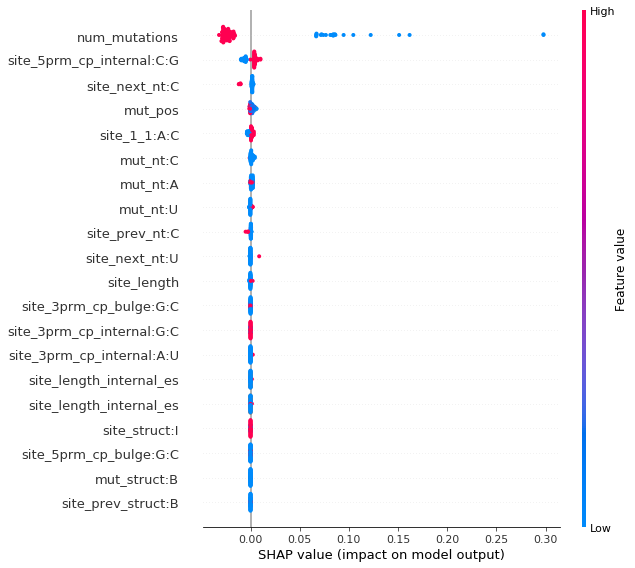

Contribution/Total:0.62181294
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_

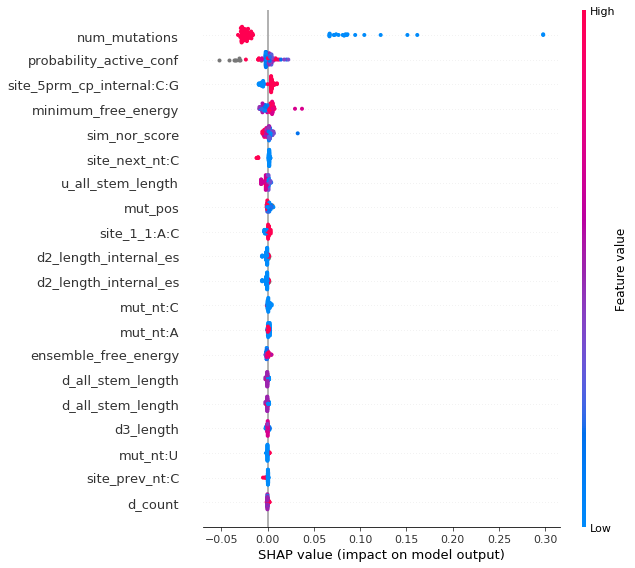

Contribution/Total:0.87817883
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*',

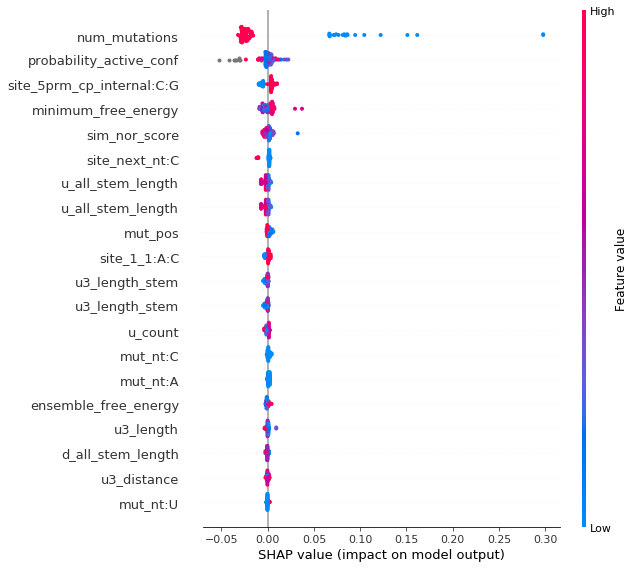

Contribution/Total:0.91111845
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


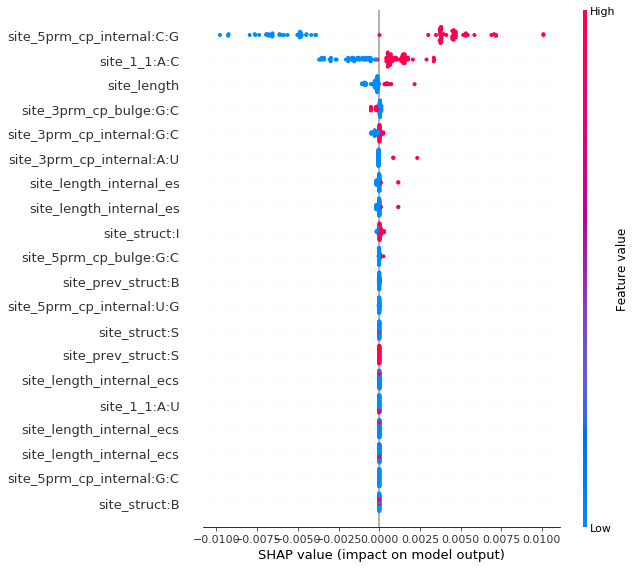

Contribution/Total:0.08031553
['site_prev_nt*', 'site_next_nt*']


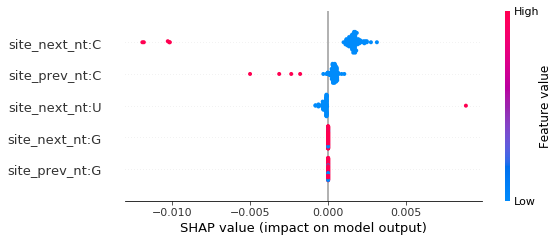

Contribution/Total:0.031964827
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


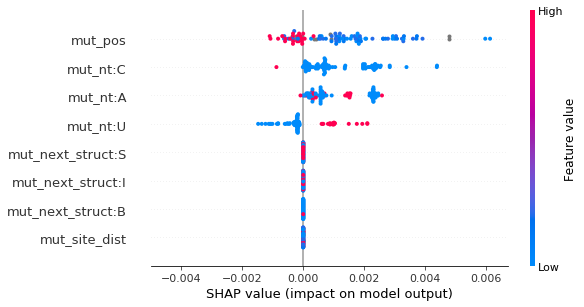

Contribution/Total:0.045655746
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


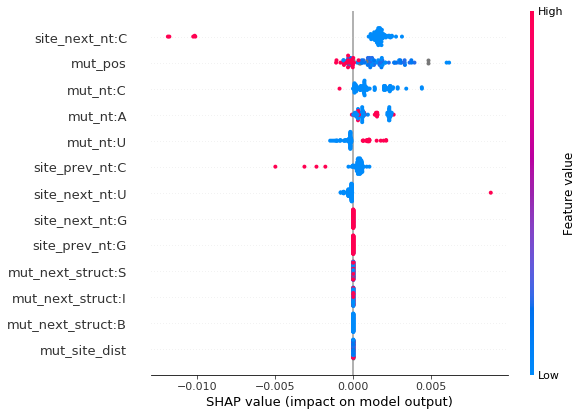

Contribution/Total:0.07762057
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

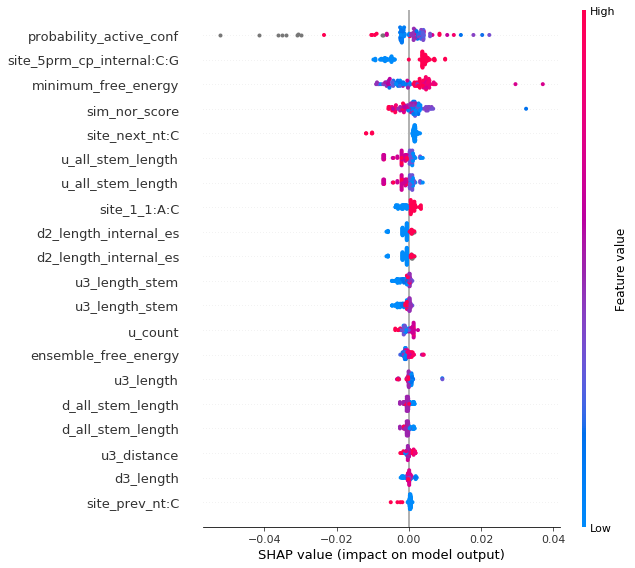

Contribution/Total:0.4685429
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


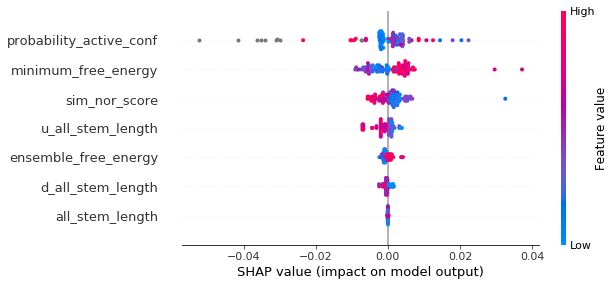

Contribution/Total:0.18940896


In [50]:
from feature_subsets import * 
subset_names=["sub_site_seq","thermodynamic","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,thermodynamic,u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [51]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [52]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [53]:
from pandas.api.types import CategoricalDtype

In [54]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)

In [55]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0             no_down     91.111845            no_down
1               no_up     87.817883              no_up
2            mut_site     62.181294           mut_site
3                 mut     50.953257                mut
4              no_mut     46.854290             no_mut
5       thermodynamic     28.285012      thermodynamic
6   overall_structure     18.940896  overall_structure
7                 u_d     16.685364                u_d
8                site     11.228035               site
9                   u      9.989661                  u
10        site_struct      8.031553        site_struct
11       mut_seq_site      7.762057       mut_seq_site
12                  d      6.695702                  d
13            mut_seq      4.565575            mut_seq
14           site_seq      3.196483           site_seq
15       sub_site_seq      3.196483       sub_site_seq
16              u1_d1      1.360481              u1_d1

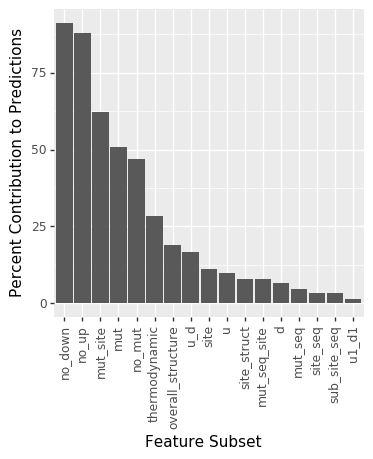

<ggplot: (8776472482177)>

In [56]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='AJUBA.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features <a name='3'>
<a href=#outline>Home</a>    

In [57]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)


In [58]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [59]:
data=format_for_xgboost(data)
random.seed(1234)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(482, 172)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 22, 84.0: 22, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 10}


In [60]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [61]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

NameError: name 'get_all_null_features' is not defined

In [62]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

u3_3prm_cp_bulge:C:G
d3_5prm_cp_internal
site_5prm_cp_bulge:C:G
u3_3prm_cp_internal:G:C
d1_struct:S
d3_5prm_cp_hairpin
d2_5prm_cp_hairpin
d2_length_hairpin
d2_3prm_cp_bulge:G:U
u3_length_hairpin
u1_struct:I
u2_length_hairpin
d3_length_hairpin
u2_5prm_cp_hairpin
u3_5prm_cp_hairpin
d3_length_internal_ecs
site_prev_nt:A
site_5prm_cp_hairpin
u3_length_internal_es
d2_5prm_cp_bulge:A:U
u1_exist
d1_length_internal_ecs
u2_5prm_cp_bulge:U:A
u3_exist
u2_length_stem
d3_struct:S
u3_length_bulge
d1_5prm_cp_bulge
d2_5prm_cp_bulge:G:U
d1_distance
d2_3prm_cp_internal:C:G
u2_exist
u3_5prm_cp_internal:A:U
d3_length_bulge
u3_length_internal_ecs
d2_5prm_cp_bulge:C:G
site_prev_struct:I
u1_3prm_cp_internal:U:A
u3_5prm_cp_bulge:C:G
d1_length_internal_es
site_next_nt:A
u3_5prm_cp_internal:G:C
u2_5prm_cp_bulge:G:C
site_length_stem
site_5prm_cp_bulge:A:U
u1_5prm_cp_internal:U:A
u2_length_bulge
d1_3prm_cp_internal
d2_3prm_cp_internal:U:A
d1_5prm_cp_internal
u3_struct:B
d3_length_internal_es
d2_length_stem
d1_exi

In [63]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [64]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [65]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(326, 90)
(326,)
(77, 90)
(77,)
(99, 90)
(99,)


In [66]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [67]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [68]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [69]:
num_round = 1000
random.seed(1234)
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.57746	eval-mae:0.31288	eval-map:1.00000	eval-aucpr:0.12237	eval-rmse:0.31988	train-auc:0.52635	train-mae:0.32400	train-map:1.00000	train-aucpr:0.06320	train-rmse:0.32835
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.71953	eval-mae:0.21931	eval-map:1.00000	eval-aucpr:0.16432	eval-rmse:0.22538	train-auc:0.68441	train-mae:0.22807	train-map:1.00000	train-aucpr:0.13624	train-rmse:0.23213
[2]	eval-auc:0.72017	eval-mae:0.15726	eval-map:1.00000	eval-aucpr:0.16503	eval-rmse:0.16145	train-auc:0.69265	train-mae:0.16112	train-map:1.00000	train-aucpr:0.14596	train-rmse:0.16529
[3]	eval-auc:0.75051	eval-mae:0.11637	eval-map:1.00000	eval-aucpr:0.17349	eval-rmse:0.12052	train-auc:0.73387	train-mae:0.11556	train-map:1.00000	train-aucpr:0.15287	train-rmse:0.11896
[4]	eval-auc:0.76270	eval-mae:0.08557	eval-map:1.00000	eval-aucpr:0.18723	eval-rmse:0.09111	train-auc:0.74128	train

[44]	eval-auc:0.79294	eval-mae:0.01643	eval-map:1.00000	eval-aucpr:0.19682	eval-rmse:0.05632	train-auc:0.81349	train-mae:0.00068	train-map:1.00000	train-aucpr:0.18381	train-rmse:0.00103
[45]	eval-auc:0.79289	eval-mae:0.01642	eval-map:1.00000	eval-aucpr:0.19681	eval-rmse:0.05631	train-auc:0.81351	train-mae:0.00063	train-map:1.00000	train-aucpr:0.18381	train-rmse:0.00097
[46]	eval-auc:0.79289	eval-mae:0.01642	eval-map:1.00000	eval-aucpr:0.19681	eval-rmse:0.05631	train-auc:0.81351	train-mae:0.00063	train-map:1.00000	train-aucpr:0.18381	train-rmse:0.00097
[47]	eval-auc:0.79289	eval-mae:0.01642	eval-map:1.00000	eval-aucpr:0.19681	eval-rmse:0.05631	train-auc:0.81351	train-mae:0.00063	train-map:1.00000	train-aucpr:0.18381	train-rmse:0.00097
[48]	eval-auc:0.79289	eval-mae:0.01642	eval-map:1.00000	eval-aucpr:0.19681	eval-rmse:0.05631	train-auc:0.81351	train-mae:0.00063	train-map:1.00000	train-aucpr:0.18381	train-rmse:0.00097
[49]	eval-auc:0.79289	eval-mae:0.01642	eval-map:1.00000	eval-aucpr:0.1

In [72]:
# save to binary file for faster loading
bst.save_model('ajuba.computational.nomut.model')
# save model to text file 
bst.dump_model('ajuba.computational.nomut.raw.txt')


In [73]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [74]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9987588907667504, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9520979824224589, pvalue=2.4591126855503185e-40)
Test:SpearmanrResult(correlation=0.9518118975988816, pvalue=1.3716777536972582e-51)


Pearson correlation:
Train:(0.9998683222200389, 0.0)
Eval:(0.7497411431867812, 4.314018297542903e-15)
Test:(0.8581697376920818, 7.651357409953648e-30)


In [75]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0006312854570042373
MAE Eval:0.0164170164540125
MAE Test:0.013205056291241886


In [76]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.0355746282869185%
MAPE Eval:12.643170213641886%
MAPE Test:17.40266378367994%


In [77]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0009711874949256264
RMSE Eval:0.05631252268983048
RMSE Test:0.03474037690618622


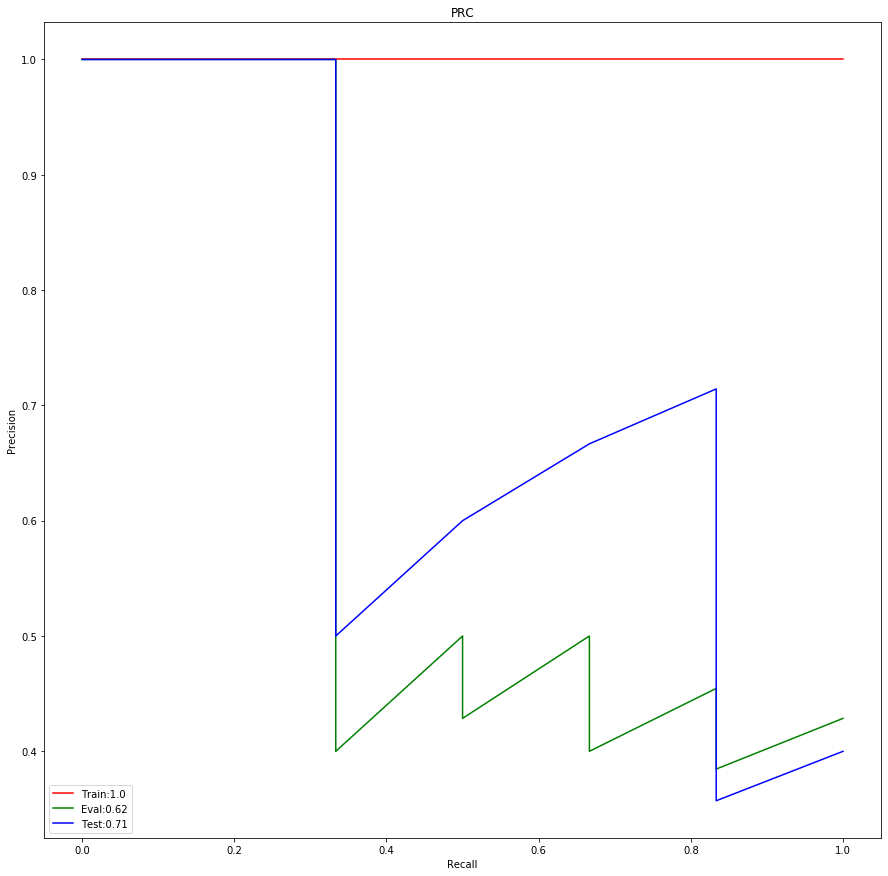

In [79]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

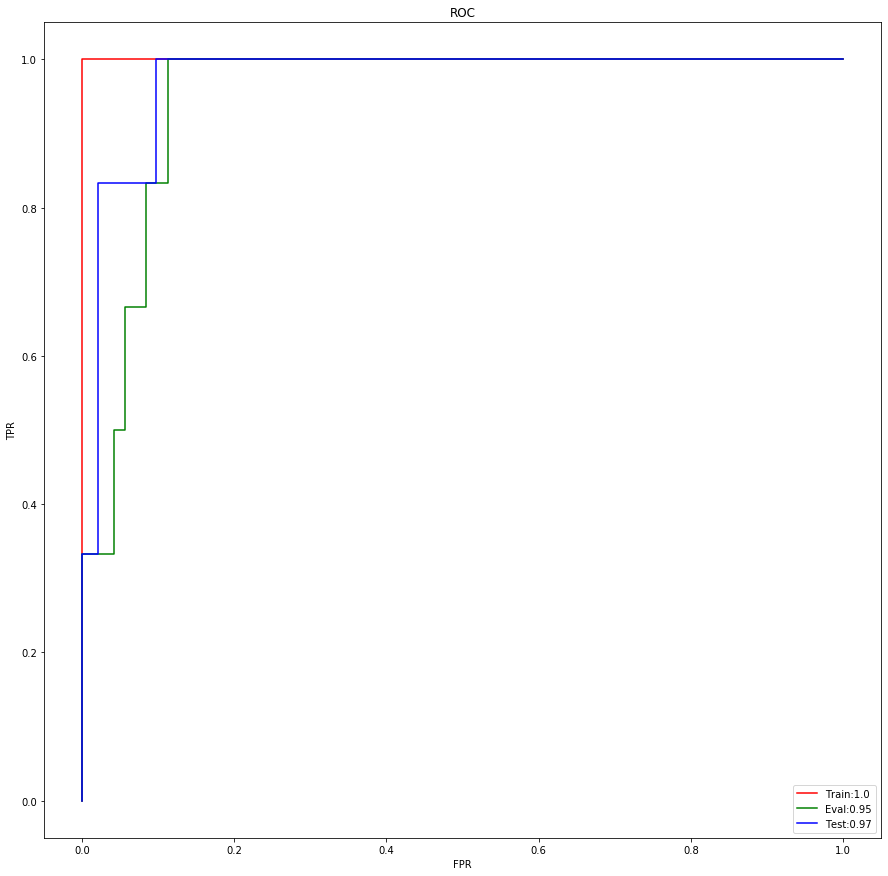

In [80]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

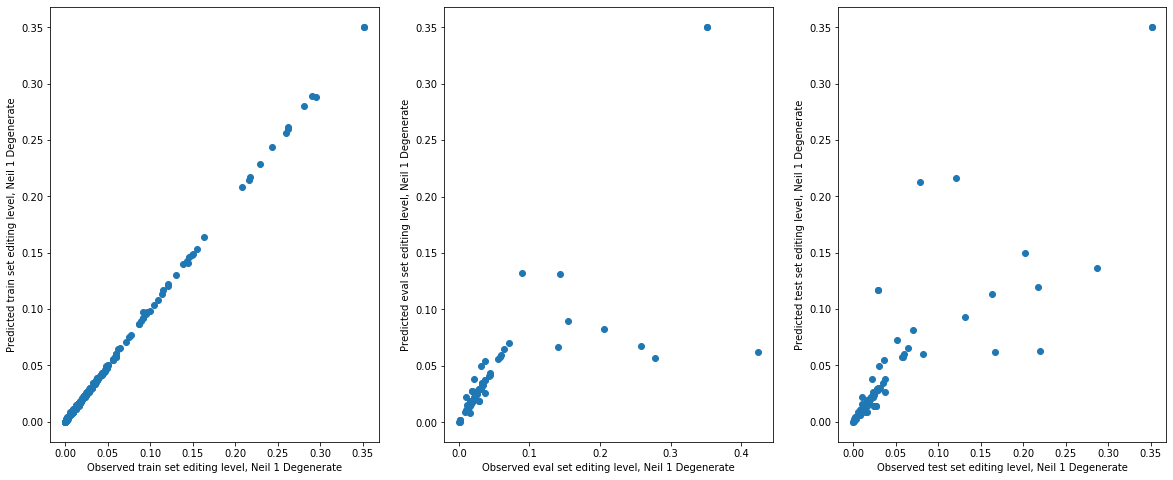

In [81]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

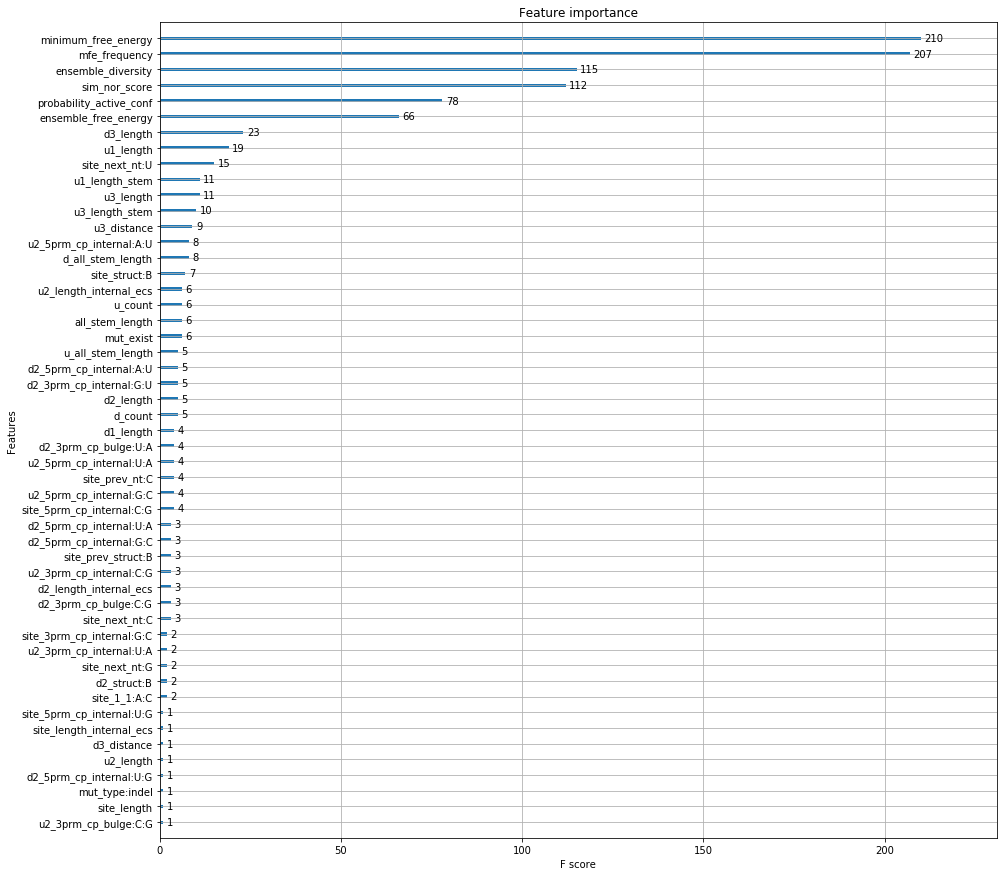

In [82]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

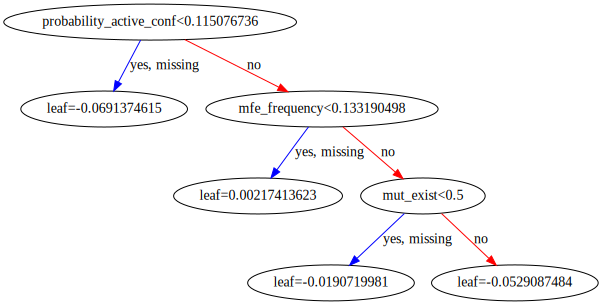

In [83]:
xgboost.to_graphviz(bst, num_trees=2)


In [84]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(99, 90)

In [88]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 

#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [89]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [90]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

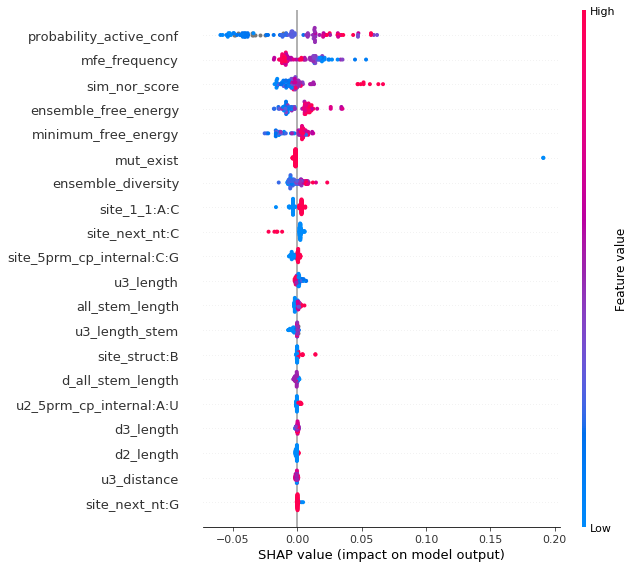

In [91]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


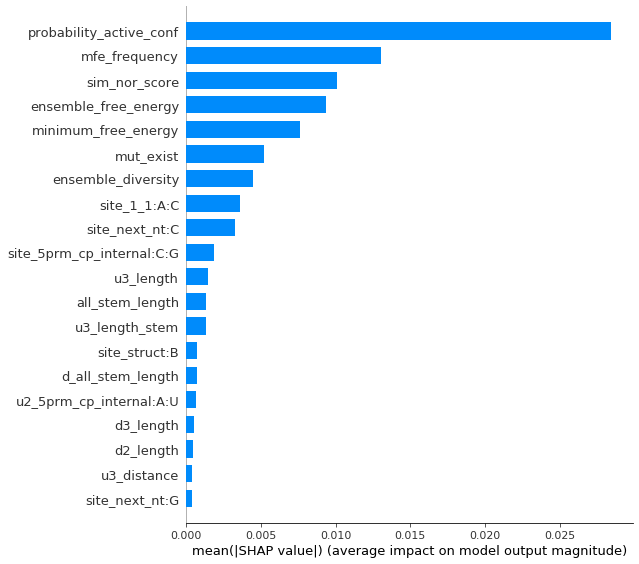

In [92]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [93]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(99, 90, 90)

In [94]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [95]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [97]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
#configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
